# NLP Hackathon

A group project with Marta Fuentes

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [86]:
df = pd.read_csv('../nlp_hackathan/data/drug_reviews_cleaned.csv')

In [87]:
df.head()

,User_ID,drugName,condition,review,rating,date,usefulCount,ratings_simplified
0,164952,Phentermine / topiramate,Weight Loss,"""I have been on the Qysmia for 3 weeks now. I...",8.0,"December 25, 2015",38,3
1,145900,Qsymia,Weight Loss,"""My Dr agreed to over see putting me on Qsymia...",9.0,"February 24, 2013",46,4
2,52117,Adipex-P,Weight Loss,"""I just started Adipex-P 37.5mg on March 6th, ...",8.0,"March 10, 2011",7,3
3,145785,Qsymia,Weight Loss,"""Began taking Qsymia 3.75 in June 2013. Its on...",10.0,"May 26, 2014",61,4
4,145840,Qsymia,Weight Loss,"""Made me jittery and could not sleep. Lost wei...",1.0,"August 21, 2013",59,1


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   User_ID             3609 non-null   int64  
 1   drugName            3609 non-null   object 
 2   condition           3609 non-null   object 
 3   review              3609 non-null   object 
 4   rating              3609 non-null   float64
 5   date                3609 non-null   object 
 6   usefulCount         3609 non-null   int64  
 7   ratings_simplified  3609 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 225.7+ KB


In [89]:
df.isna().sum()

User_ID               0
drugName              0
condition             0
review                0
rating                0
date                  0
usefulCount           0
ratings_simplified    0
dtype: int64

In [90]:
# dropping unecessary columns
df.drop(columns = ['User_ID', 'rating', 'date', 'usefulCount'], inplace = True)

In [91]:
df.head()

,drugName,condition,review,ratings_simplified
0,Phentermine / topiramate,Weight Loss,"""I have been on the Qysmia for 3 weeks now. I...",3
1,Qsymia,Weight Loss,"""My Dr agreed to over see putting me on Qsymia...",4
2,Adipex-P,Weight Loss,"""I just started Adipex-P 37.5mg on March 6th, ...",3
3,Qsymia,Weight Loss,"""Began taking Qsymia 3.75 in June 2013. Its on...",4
4,Qsymia,Weight Loss,"""Made me jittery and could not sleep. Lost wei...",1


In [92]:
# create X and y

X = df['review']
y = df['ratings_simplified']

In [93]:
# baseline accuracy - '4' predicts a 63.8% accuracy
y.value_counts(normalize = True)

ratings_simplified
4    0.638681
3    0.159601
1    0.115267
2    0.086451
Name: proportion, dtype: float64

In [94]:
# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 123, stratify = y)

# Pre-Processing

  - Remove special characters
  - Tokenizing
  - Lemmatize/Stemming
  - Stop word removal

In [96]:
# Instantiate a CountVectorizer
cvec = CountVectorizer()

In [97]:
# Fit the vectorizer on our corpus
cvec.fit(X_train)

CountVectorizer()

In [98]:
# Transform the corpus
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [99]:
type(X_train)

scipy.sparse._csr.csr_matrix

In [100]:
X_train_df = pd.DataFrame(X_train.todense(),
                          columns = cvec.get_feature_names_out())

In [101]:
# plot top occuring words

X_train_df.head()

,00,000,00am,00pm,01,02,03,039,04,05,...,zine,zipped,zoloft,zombie,zone,zoned,zquil,zumba,zyban,zzzquil
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

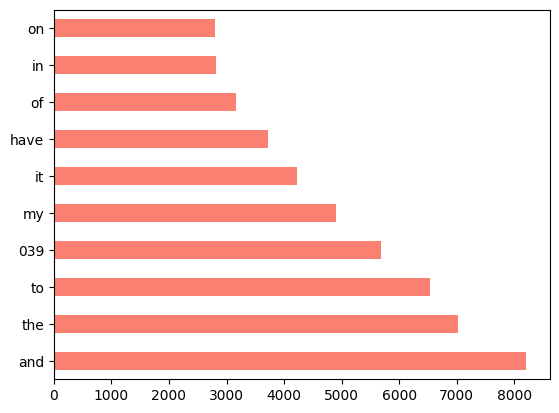

In [102]:
X_train_df.sum().sort_values(ascending= False).head(10).plot(kind = 'barh', color='salmon')

# A Reminder on Using CountVerctorizer's hyperparameters
  - stop_words
  - max_features: used to only include the N most popular vocab words in our corpus
  - max_df: if max_df = .98, ignore the words that occur in >98% of the docs in corpus
  - min_df: if min_df = 2, a word must occur in at least two docs from the corpus
  - ngram_range: capture n-word phrases

Both max_df and min_df can accept either an integer or a float.

  - An integer tells us the number of documents.
  - A float tells us the percentage of documents.

---

Setting up for using MultinomialNB() as an estimator after transforming with CountVectorizer() and doing a gridsearch to find the best parameters for count vectorizer so that we get the best model possible using MultinomialNB()

In [106]:
# re teaching it what X and y are, since above, we transformed them with cvec already.

X = df['review']
y = df['ratings_simplified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 123, stratify = y)

In [107]:
# Our first pipeline will have two stages: cvec and nb
# cvec is our Count Vectorizer --> transforms the data
# nb is our estimator/model to make predictions
# once we set up the pipeline, we have to figure out the best params
# for cvec, which we do using a GridsearchCV

# Established what pipe1 is
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [108]:
# use gridsearch to fid the best parameter for 'cvec' 
# tuning our cvec by loading pipeline into GridSearch

pipe1_params = {'cvec__max_features': [2000, 4000, 6000, 8000], #max no of features it will fit
                'cvec__min_df' : [2, 3], # if min_df = 2, a word must occur in at least two docs from the corpus
                'cvec__max_df' : [0.9, 0.95, 0.98],
                'cvec__ngram_range' : [(1,1), (1,2), (1,3)]
}
# now we have established the combinations we want our Gridsearch to use in cvec to optimize scores

In [109]:
# Instantiate GridSearchCV as gs

gs = GridSearchCV(pipe1, # object we are optimizing
                  pipe1_params, #optimize based on these choices
                  cv = 5) # use cross_val_score to figure out optimum choices

In [110]:
# Fit GridSearch to training data
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cvec__max_features': [2000, 4000, 6000, 8000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [134]:
#What was the best score it decided on when it GridSearched
gs.best_score_

0.778271071065609

In [136]:
gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 8000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

# Lets try to tune one more time, based on the different params that Marta and I got.
Holly's work for a best score of 0.7782:

pipe2_params = {
    ‘cvec__max_features’: [2000, 5000, 8000],
    ‘cvec__min_df’: [2, 3],
    ‘cvec__max_df’: [0.95, 0.98],
    ‘cvec__ngram_range’: [(1, 1), (1, 2)]
}

{'cvec__max_df': 0.95,
 'cvec__max_features': 8000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

Marta's work for a best score of 0.777

pipe_params = {'cvec__max_features': [2000, 3000, 4000, 5000], #Maximum number of features fit: 2000...
cvec__min_df': [2, 3], #Min number of documents needed to include token: 2, 3
               'cvec__max_df': [0.9, 0.95], #Maximum number of docs needed to include token: 90%, 95%
               'cvec__ngram_range': [(1, 1), (1,2)] # check (individual tokens) and also check (individual tokens and 2-grams)
              }

{'cvec__max_df': 0.9, 
 'cvec__max_features': 8000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}


In [141]:
# let's see if we can improve our score by using values both of our models picked 
# and fine tuning the rest
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])


pipe3_params = {
    'cvec__max_features': [8000, 8100],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.98, 0.99],
    'cvec__ngram_range': [(1, 2), (1, 3)]
}



gs = GridSearchCV(pipe3, # object we are optimizing
                  pipe3_params, #optimize based on these choices
                  cv = 5) # use cross_val_score to figure out optimum choices

In [143]:

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.98, 0.99],
                         'cvec__max_features': [8000, 8100],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (1, 3)]})

In [145]:
gs.best_score_

0.779750496211062

In [147]:
# re teaching it what X and y are, since above, we transformed them with cvec already.

X = df['review']
y = df['ratings_simplified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 123, stratify = y)

# Our best score is with
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])
    
pipe_params = {
    'cvec__max_features': [2000, 5000, 8000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.95, 0.98],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

gs = GridSearchCV(pipe, # object we are optimizing
                  pipe_params, #optimize based on these choices
                  cv = 5) # use cross_val_score to figure out optimum choices

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.95, 0.98],
                         'cvec__max_features': [2000, 5000, 8000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [148]:
print(f'Best training Score: {gs.best_score_}')
print('='*20)
print(f'Best training params: {gs.best_params_}')

Best training Score: 0.778271071065609
Best training params: {'cvec__max_df': 0.95, 'cvec__max_features': 8000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}


In [149]:
gs.score(X_train, y_train)

0.9360679970436068

In [150]:
gs.score(X_test, y_test)

0.770764119601329

# Interpreting the results of our model.
Overfit: the model learned the training data too well, likely captured noise that exists in the training data but not in the testing data. It's not generalizing to new data well.

High Variance: It's likely that our model is too complex

Do we have data leakage? I made sure to redifine our X matrix and y, then split and ran my pipeline all in the same cell. Making sure .fit was only called on training data.

# Possible next steps
Simplify did we use too many features? We don't think we used too many features, as the best scores were using the parameter with 8000

Did we choose the most relevant features? Do not believe so, we should try a different pipe that looks through stop words better. Next step is likely SpaCy.